In [51]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib import colors
import seaborn as sns; sns.set()

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

import pandas as pd

np.random.seed(1234)

In [52]:
# iris データを読み込んで諸元を表示してみる
iris = datasets.load_iris()

# データをデータフレーム化しておこう

X_data = iris['data']

# 各クラスの名前リストを作っておこう
class_data = [iris['target_names'][cid] for cid in iris['target']]

df_Data = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
df_Class = pd.DataFrame(data=class_data, columns=['Class'])

# データフレームを結合しておく
df = pd.concat([df_Class, df_Data], axis=1)

# sepal length,petal widthで実験

c:\Users\theko\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\theko\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


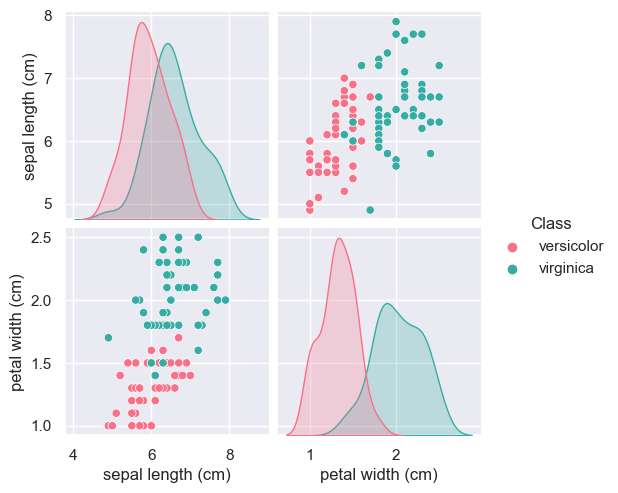

In [53]:
# 'setosa' を除外した2クラスで特徴量を絞ってのデータフレームを作って散布図をとってみる
# 0, 1, 3 はカラム指定で第０カラムがクラス名，第１，第３が所望の特徴量
df_limited = df[df['Class'] != 'setosa'].iloc[:, [0, 1, 4]]
sns.pairplot(df_limited, hue='Class', palette="husl")

In [54]:
# 学習データと評価データをわける．

# 一応データフレームのままでも扱えるが，numpy の型へ戻しておこう．
# とくに欠損などの処理もないので

# 第０カラムがクラスラベル，第１カラム以降が数値データ
X = df_limited.iloc[:, 1:].values

# y = df_limited.iloc[:, 0].values
# とすると，'versicolor', 'virginica' からなる配列が得られる．
# sklearn は優秀なのでこのままでも取り扱えるけど，まえのノートの関数を
# そのまま使うとすると，平均とか求めるケースもあるので，ここでは数値化して ±1 ラベルを与える．
# この場合には values ではなく, 
# pd.get_dummies(y) を用いる．すると one-hot-vector が得られるので
# 第１列のみをデータとする．すなわち 'versicolor':1 , 'verginica':0 というラベルがでてくる
# あとは，これを2倍して1を引けば±１になる

y_dummy = pd.get_dummies(df_limited.iloc[:, 0]).values
y = 2 * y_dummy[:, 0].astype(int) - 1

# で，学習データと評価データに分割
# これも train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [55]:
def draw_boundary(w, ax, x_rng=(0, 1), y_rng=(0, 1)):
    '''
    境界線を引く関数
    '''
    # w0 + w1 x1 + w2 x2 = 0 が分離境界のはずなので
    # x2 = (w0 + w1 x1) / (-w2) が境界線
    xx = np.linspace(x_rng[0], x_rng[1])
    yy = (w[0] + w[1] * xx) / (-w[2])
    
    im = ax.plot(xx, yy, 'g-', linewidth=3)
    
    return im


def draw_prob(w, ax, x_rng=(0, 1), y_rng=(0, 1), alpha=0.8):
    '''
    確率を描画する関数
    '''
    # w0 + w1 x1 + w2 x2 = 0 が分離境界のはずなので
    # x2 = (w0 + w1 x1) / (-w2) が境界線
    xx = np.linspace(x_rng[0], x_rng[1])
    yy = (w[0] + w[1] * xx) / (-w[2])
    
    xx, yy = np.meshgrid(np.linspace(x_rng[0], x_rng[1], 256),
                         np.linspace(y_rng[0], y_rng[1], 256))
    mesh_dat = np.c_[xx.ravel(), yy.ravel()]
    Z = y_prob(mesh_dat, w)
    Z = Z.reshape(xx.shape)
    
    ax.pcolormesh(xx, yy, Z, cmap='coolwarm', norm=colors.Normalize(0., 1.), zorder=0, alpha=alpha)
    im = ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # im = ax.plot(xx, yy, 'g-', linewidth=3)
    
    return im
    
    
def draw_data(ax, X, y, label_1=None, label_2=None, symbol_1='ro', symbol_2='bo', alpha=0.5, x_rng=(0, 1), y_rng=(0, 1)):
    '''
    散布図を描画する関数
    '''
    ax.plot(X[y==1, 0], X[y==1, 1], symbol_1, alpha=alpha, label=label_1)
    ax.plot(X[y!=1, 0], X[y!=1, 1], symbol_2, alpha=alpha, label=label_2)

Text(0.5, 1.0, 'Iris Data')

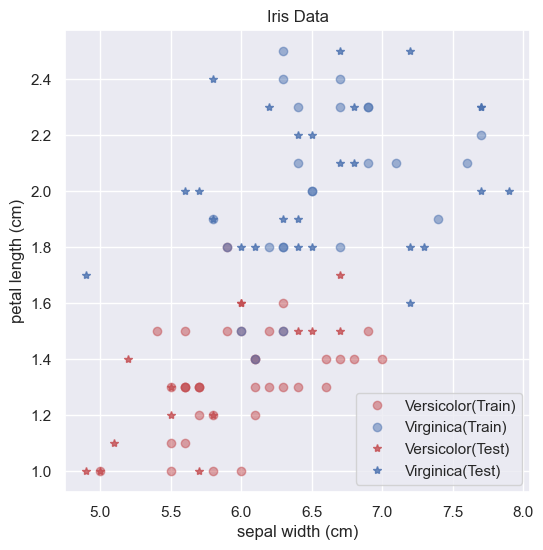

In [56]:
# データがどういう分布になっているか，散布図で確認
fig, ax = plt.subplots(figsize=(6, 6))

draw_data(ax, X_train, y_train, label_1='Versicolor(Train)', label_2='Virginica(Train)', symbol_1='ro', symbol_2='bo', alpha=0.5)
draw_data(ax, X_test, y_test, label_1='Versicolor(Test)', label_2='Virginica(Test)', symbol_1='r*', symbol_2='b*', alpha=0.8)
ax.legend()
ax.set_xlabel('sepal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.set_title('Iris Data')

In [57]:
X_Center = X_train.mean(axis=0)
X_train = (X_train - X_Center) 

print('学習データの幅（補正後）', X_train.max(axis=0) - X_train.min(axis=0))
print('学習データの中心（補正後）', X_train.mean(axis=0))

# テストデータの方も補正しておこう

X_test = (X_test - X_Center) 

print('評価データの幅（補正後）', X_test.max(axis=0) - X_test.min(axis=0))
print('評価データの中心（補正後）', X_test.mean(axis=0))

学習データの幅（補正後） [2.7 1.5]
学習データの中心（補正後） [7.10542736e-16 5.69914486e-16]
評価データの幅（補正後） [3.  1.5]
評価データの中心（補正後） [0.08416667 0.19      ]


Text(0.5, 1.0, 'Iris Data')

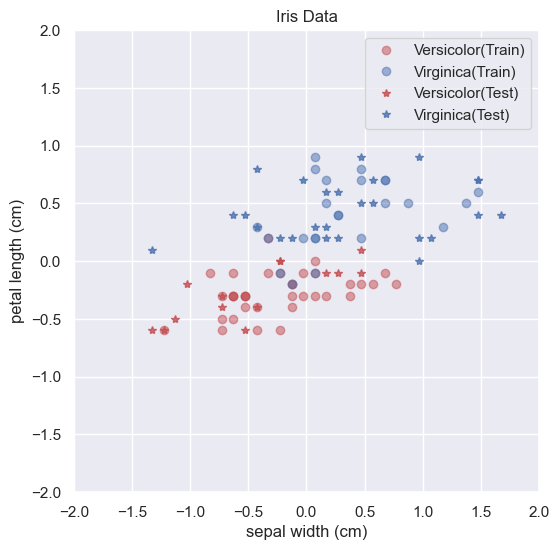

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

draw_data(ax, X_train, y_train, label_1='Versicolor(Train)', label_2='Virginica(Train)', symbol_1='ro', symbol_2='bo', alpha=0.5)
draw_data(ax, X_test, y_test, label_1='Versicolor(Test)', label_2='Virginica(Test)', symbol_1='r*', symbol_2='b*', alpha=0.8)
ax.legend()
ax.set_xlabel('sepal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title('Iris Data')

# LDA

In [59]:
def predictLDA(x, w, w0):
    return np.sign(w @ x.T + w0)


def SolverLDA(x, y):
    '''
    x はベクトル(D次元なので (N, D) な行列として受け取る)，y はラベル（N次元）
    LDA で回帰平面を求めるソルバー
    '''   
    # とりあえずデータの中心化から
    Ex = x.mean(axis=0)
    new_x = x - Ex
    
    # クラスごとにデータを分割しておく
    # x_1 = new_x[y == +1, :]
    # x_2 = new_x[y == -1, :]
    # N_1 = np.sum(y == +1)
    # N_2 = np.sum(y == -1)

    # クラスラベルの仮定が合わないのでちょっとだけ修正
    x_1 = new_x[y == 1, :]
    x_2 = new_x[y != 1, :]
    N_1 = np.sum(y == 1)
    N_2 = np.sum(y != 1)
    
    u_1 = x_1.mean(axis=0) # クラス１の重心
    u_2 = x_2.mean(axis=0) # クラス２の重心
    
    S_w = (x_1 - u_1).T @ (x_1 - u_1) / N_1 + (x_2 - u_2).T @ (x_2 - u_2) / N_2
    
    w = np.linalg.solve(S_w, u_1 - u_2)
    w_0 = 0
    
    # あとは中心化で平行移動した分をずらしておく
    # y(x) = w^T new_x + w_0 として解いていて new_x = x - E_x なので
    # w^T (x - E_x) + w_0 = 0 を開くと w^T x - w^T E_x + w_0 = 0
    
    w_0 = w_0 - w @ Ex
    
    return w, w_0

誤り個数 1


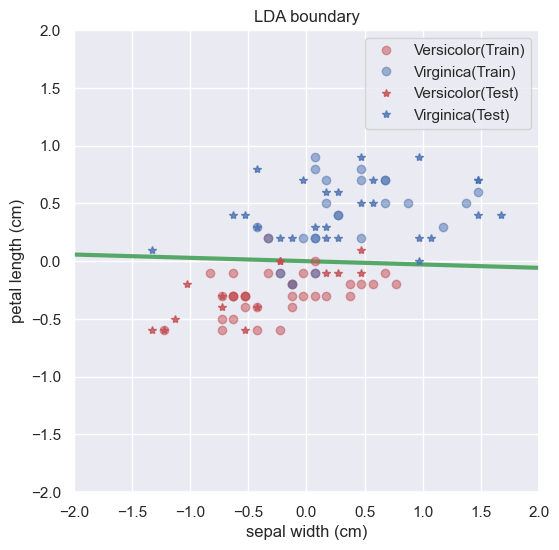

In [60]:
# 解いてみよう
w_tmp, w_0 = SolverLDA(X_train, y_train)

# w_0, w の順に並べて一つの配列に
w = np.array([w_0, w_tmp[0], w_tmp[1]])

# 描画
fig, ax = plt.subplots(figsize=(6, 6))

draw_boundary(w, ax, x_rng=(-2, 2), y_rng=(-2, 2))

draw_data(ax, X_train, y_train, label_1='Versicolor(Train)', label_2='Virginica(Train)', symbol_1='ro', symbol_2='bo', alpha=0.5)
draw_data(ax, X_test, y_test, label_1='Versicolor(Test)', label_2='Virginica(Test)', symbol_1='r*', symbol_2='b*', alpha=0.8)
ax.legend()
ax.set_xlabel('sepal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title('LDA boundary')

# 誤り個数を計算してみる
y_pred = predictLDA(X_test, w_tmp, w_0)
y_err = np.count_nonzero(y_pred - y_test)

print('誤り個数', y_err)

# rogistic

In [61]:
from sklearn.linear_model import LogisticRegression

# sklearn のロジスティック回帰は L2 正則化が入っていて，これの効きの大きさの逆数をパラメータCで与える
classifier = LogisticRegression(C=1000)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

y_err = np.count_nonzero(y_pred - y_test)

print('誤り個数', y_err)


誤り個数 2


In [62]:
# で，結果は 
# classifier.coef_, に，重み情報
# classifier.intercept_ に切片情報が入る．
# 
w = np.array([classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1]])

print(w / np.sqrt(w @ w))

[ 0.03197069 -0.05523991 -0.99796113]


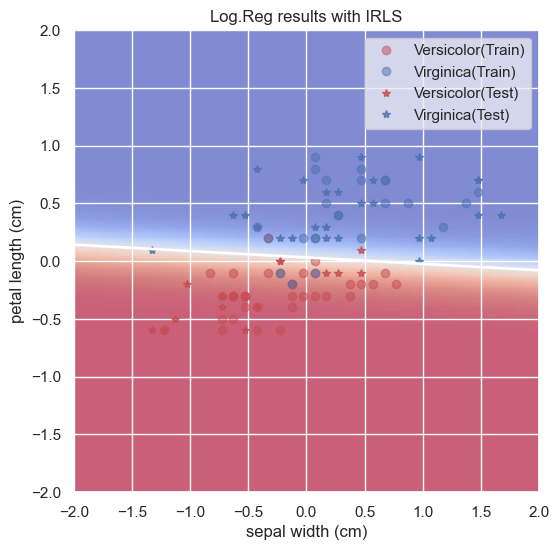

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))

# データ点の描画
draw_data(ax, X_train, y_train, label_1='Versicolor(Train)', label_2='Virginica(Train)', symbol_1='ro', symbol_2='bo', alpha=0.5)
draw_data(ax, X_test, y_test, label_1='Versicolor(Test)', label_2='Virginica(Test)', symbol_1='r*', symbol_2='b*', alpha=0.8)
ax.legend()
ax.set_xlabel('sepal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title('Log.Reg results with IRLS')

draw_prob(w, ax, x_rng=(-2, 2), y_rng=(-2, 2), alpha=0.6)